<a href="https://colab.research.google.com/github/hongsy0113/cose461-NLP-project-choi-hong/blob/main/lstm_%EB%94%B0%EB%9D%BC%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install soynlp
!pip install konlpy
from soynlp.normalizer import *
import soynlp




     |████████████████████████████████| 416 kB 15.7 MB/s 
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 448 kB 65.5 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:

import json
from pandas import json_normalize

import torch
from torch import nn

import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
# json data 파일들을 google drive에 저장
# google drive 에 있는 파일들을 접근하기 위해 mount
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Convert json file to dataFrame
# input file parameter should be str, path and name of json file
# output dataFrame contains utterances. 
# each utterance has dialogueInfo and participantsInfo (i.e gender)

def json2df (file):
  with open(file, 'r') as f:
    jdata = json.load(f)
  
  meta_list = [['header', 'dialogueInfo', 'numberOfParticipants'],
             ['header', 'dialogueInfo', 'numberOfUtterances'],
             ['header', 'dialogueInfo', 'numberOfTurns'],
             ['header', 'dialogueInfo', 'type'],
             ['header', 'dialogueInfo', 'topic'],
             ['header', 'dialogueInfo', 'dialogueID'],
            ]
  # dataframe of utterances 
  df1 = pd.json_normalize(jdata['data'][:], record_path=['body'], meta= meta_list, errors='ignore')
  # dataframe of participants info
  df2 = pd.json_normalize(jdata['data'], record_path=['header', 'participantsInfo'],  meta= [['header', 'dialogueInfo', 'dialogueID']], errors='ignore')
  # join df1 and df2 where (df1.dialogueID == df2.dialogueID and df1.participantID == df2.participantID)
  df = pd.merge(left = df1 , right = df2, how = "left", on = ["header.dialogueInfo.dialogueID", 'participantID' ],sort=False)

  # rename column names
  # 열이름 너무 길어서 바꿈. P는 참가자, U는 메시지, D는 대화, T는 turn 으로 통일시킴. 맘에 안 들면 바꿔도 ok
  df.rename(columns = {'header.dialogueInfo.numberOfParticipants' : 'P_num', 
                       'header.dialogueInfo.numberOfUtterances': 'U_num', 
                       'header.dialogueInfo.numberOfTurns':'T_num',
                       'header.dialogueInfo.type': 'D_type',
                       'header.dialogueInfo.topic': 'D_topic',
                       'header.dialogueInfo.dialogueID':'D_id',
                       'utteranceID':'U_id',
                       'participantID':'P_id',
                       'turnID':'T_id',
                       'date':'U_date',
                       'gender':'P_gender',
                       'residentialProvince':'P_residential',
                       'age':'P_age'}, inplace = True)
  # 대화 id, utterance id 를 index로 함. 마찬가지로 수정해도 됨.
  df.set_index(['D_id','U_id'], inplace=True)
  return df


In [4]:
# 행사.json, 식음료.json 등 여러 데이터셋을 하나로 만들기 위한 함수
def concat_json2df (file_list):
  result = None

  for i, file in enumerate(file_list):
    df = json2df(file)
    if (i==0):
      result = df.copy()
    else:
      result = pd.concat([result,df])
  return result

In [5]:
#f_list = ['/content/gdrive/MyDrive/cose461/행사.json',
#          '/content/gdrive/MyDrive/cose461/식음료.json']
f_list = ['/content/gdrive/MyDrive/cose461/일과직업.json']



df = concat_json2df(f_list)

#test3.describe()
df

utterance  ... P_gender
D_id                                 U_id                   ...         
b389d045-aa23-5e1e-af64-7406b1ad921c U1      여러 명 같이 하나보네?  ...       여성
                                     U2            #@이모티콘#  ...       여성
                                     U3           응 한 10명?  ...       여성
                                     U4      프로그램 다운이 안 됐대  ...       여성
                                     U5                  아  ...       여성
...                                                    ...  ...      ...
7a34f374-c380-5d44-9d97-5f00ff601e2b U13          밖에서 은근슬쩍  ...       여성
                                     U14            #@이름#씨  ...       여성
                                     U15              말놓는다  ...       여성
                                     U16   오 둘이 동갑이야~? 이러면  ...       여성
                                     U17     아뇨? 저 30살인데요!  ...       여성

[1166093 rows x 13 columns]

# 1. lstm 모델

https://wikidocs.net/44249 
이 내용 거의 따라함

그냥 raw 하게 각 메시지의 화자 성별을 예측하도록

In [6]:
from soynlp.tokenizer import RegexTokenizer
from soynlp.normalizer import *

tokenizer = RegexTokenizer()

/usr/local/lib/python3.7/dist-packages/soynlp/tokenizer/_tokenizer.py:19: FutureWarning: Possible nested set at position 13
  ('english & latin', re.compile(u"[a-zA-ZÀ-ÿ]+[[`']?s]*|[a-zA-ZÀ-ÿ]+", re.UNICODE))


In [7]:
# Naive-Bayes Method.
df = df[['utterance', 'P_gender']]
df['P_gender'].value_counts()

여성    970761
남성    195332
Name: P_gender, dtype: int64

In [8]:
# Gender to discrete variable
# 0 : '여성', 1 : '남성'
df['P_gender'] = [0 if gender=='여성' else 1 for gender in df['P_gender']]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


utterance  P_gender
D_id                                 U_id                           
b389d045-aa23-5e1e-af64-7406b1ad921c U1      여러 명 같이 하나보네?         0
                                     U2            #@이모티콘#         0
                                     U3           응 한 10명?         0
                                     U4      프로그램 다운이 안 됐대         0
                                     U5                  아         0
...                                                    ...       ...
7a34f374-c380-5d44-9d97-5f00ff601e2b U13          밖에서 은근슬쩍         0
                                     U14            #@이름#씨         0
                                     U15              말놓는다         0
                                     U16   오 둘이 동갑이야~? 이러면         0
                                     U17     아뇨? 저 30살인데요!         0

[1166093 rows x 2 columns]

In [9]:

"""
# soynlp 의 repeat_normalzie 함수
# 반복되는 글자들을 num_repeat 수 만큼 통일시킨다.
# 그냥 이 함수를 쓸까 하다가 다 똑같이 통일하면 의미를 온전히 표현 못할 수도 있을거 같아서 나중에 필요하면 ㅋㅋㅋ 개수를 threshold를 기준으로 분류하든지

def repeat_normalize(sent, num_repeats=2):
    if num_repeats > 0:
        sent = soynlp.repeatchars_pattern.sub('\\1' * num_repeats, sent)
    sent = doublespace_pattern.sub(' ', sent)
    return sent.strip()
"""
def my_repeat_normalize(sent, num_repeats=2):
    if num_repeats > 0:
        sent = soynlp.repeatchars_pattern.sub('\\1' * num_repeats, sent)
    sent = doublespace_pattern.sub(' ', sent)
    return sent.strip()


In [10]:
# soynlp 설명 참고 링크
#https://github.com/lovit/soynlp
# df['utterance'] 에서 ㅋㅋㅋㅋㅋ와 같이 반복되는 글지 normalize 하고 tokenize

def text_normalize(sent):
  #result= emoticon_normalize(sent, num_repeats= 2)
  result = tokenizer.tokenize(sent)
  for i, token in enumerate(result):  
    tmp = emoticon_normalize(token, num_repeats= 2)
    result[i] = repeat_normalize(tmp, num_repeats=1)
    #result[i] = tmp
    pass
  return result

df['sents'] = df['utterance'].apply(text_normalize)
df.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


utterance  ...                       sents
D_id                                 U_id                     ...                            
b389d045-aa23-5e1e-af64-7406b1ad921c U1        여러 명 같이 하나보네?  ...        [여러, 명, 같이, 하나보네, ?]
                                     U2              #@이모티콘#  ...               [#@, 이모티콘, #]
                                     U3             응 한 10명?  ...            [응, 한, 10, 명, ?]
                                     U4        프로그램 다운이 안 됐대  ...          [프로그램, 다운이, 안, 됐대]
                                     U5                    아  ...                         [아]
                                     U6            강제로 쉬는 시간  ...               [강제로, 쉬는, 시간]
                                     U7    평일엥 일하겠네 우리 #@이름#  ...  [평일엥, 일하겠네, 우리, #@, 이름, #]
                                     U8               평일엔...  ...                  [평일엔, ...]
                                     U9              다음 주부터는  ...                  [다음, 주부터는]
                                     U10                바쁘겠다  ...                      [바쁘겠다]

[10 rows x 3 columns]

데이터 전처리 고려해야 할 점 ㅜㅜ

- ㅋㅋㅋㅋ, ㅇㅇㅇㅇ 어떻게 처리할지. 단순히 여러개 있어도 다 같은 걸로 취급할지 말지
- !, ? 도 마찬가지. soynlp의 textonly 함수를 통해 기호들은 제거가 쉽게 가능할듯 한데. 그럼 정보의 손실이 있을수도
- 이모티콘 이름. 우리 데이터에서 사람 이름은 #@이름# 으로 되어있음. 
- 형태소 분석

In [11]:
### word embedding 만들기 위해 corpus 처럼 만들자
my =df['sents'].values
my = my.tolist()


In [34]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim

embedding = gensim.models.Word2Vec(my, size=10, window=7, negative=3, min_count=0)
embedding.save('word2vec.model')  # weight vector 모델을 저장합니다.

model_ = gensim.models.Word2Vec.load('word2vec.model') # Weight Vector 모델을 볼러와 유사한 단어를 예측합니다.
print(model_.wv['선풍기'])
print(model_.most_similar('선풍기'))

[ 0.02112307  0.03254147  0.04768515 -0.0029393   0.00822681 -0.02255999
  0.03092879  0.01184177  0.04574927 -0.04614364]
[('엄마한테', 0.8329931497573853), ('ㅈ', 0.8307013511657715), ('이모가', 0.8080521821975708), ('딱딱', 0.7413960695266724), ('창문은요', 0.6837728023529053), ('일대일하던가', 0.6676013469696045), ('!', 0.6529248952865601), ('그전에', 0.610842227935791), ('일하고와서', 0.5693598985671997), ('봅시당', 0.5555441975593567)]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.


In [12]:
df_women = df[df['P_gender']==0]
df_men = df[df['P_gender']==1]

print("Number of women : {}, Number of men : {}".format(df_women['P_gender'].value_counts()[0], df_men['P_gender'].value_counts()[1]))

Number of women : 970761, Number of men : 195332


In [13]:
df_women = df_women.sample(n= df_men['P_gender'].value_counts()[1], random_state=7)
df = pd.concat([df_women, df_men], sort=True)
df.head()

,,P_gender,sents,utterance
D_id,U_id,,,
87da480b-5ddf-5d22-a259-fb454f7185df,U5,0,"[면대면이, 아니니, 스트레스가, 덜하고, ..., 숨고통해서, 하면, 안전번호라,...",면대면이 아니니 스트레스가 덜하고...숨고통해서 하면 안전번호라 내 번호 그사람 번...
dc003b02-9594-5f3d-a788-a537bd4c44e7,U22,0,"[#@, 이름, #, 과장님이, #@, 이름, #, 씨, 오케이랫다는데]",#@이름#과장님이 #@이름#씨 오케이랫다는데
7b079598-ae06-578b-8de1-b4f0667d704f,U1,0,"[나보다, 윗사람, 대할때]",나보다 윗사람 대할때
d0a6d807-0e24-5db8-add6-8fdf4c3a72e5,U3,0,"[생리, 할때마다, 저래, 진짜, 짜증나게, 한달에, 하루이틀씩]",생리 할때마다 저래 진짜 짜증나게 한달에 하루이틀씩
cdbc850f-ae91-5524-8098-3b29e5f924ac,U11,0,"[이, 연극을, 통해, 보여주고, 싶은, 것, ,,]","이 연극을 통해 보여주고 싶은 것,,"


In [14]:
X = df['sents']
y = df['P_gender']

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=7)



In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [16]:
print(tokenizer.word_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 206798
등장 빈도가 2번 이하인 희귀 단어의 수: 183972
단어 집합에서 희귀 단어의 비율: 88.9621756496678
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 26.57525164006852


In [18]:
# 전체 단어 개수 중 빈도수 threshold 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 22827


In [19]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
y_train = np.array(y_train)
y_test = np.array(y_test)

메시지의 최대 길이 : 393
메시지의 평균 길이 : 2.37170538997773


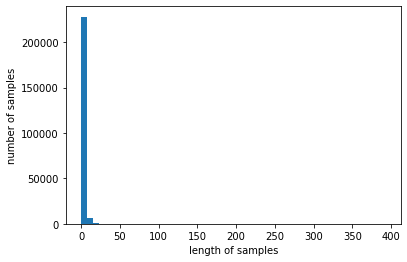

In [21]:
print('메시지의 최대 길이 :',max(len(l) for l in X_train))
print('메시지의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

below_threshold_len(10,X_train)

전체 샘플 중 길이가 10 이하인 샘플의 비율: 99.10920741644553


In [28]:
max_len = 10
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [29]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
2929/2930 [============================>.] - ETA: 0s - loss: 0.6762 - acc: 0.5705
Epoch 00001: val_acc improved from -inf to 0.57575, saving model to best_model.h5
2930/2930 [==============================] - 155s 52ms/step - loss: 0.6762 - acc: 0.5705 - val_loss: 0.6726 - val_acc: 0.5757
Epoch 2/15
2929/2930 [============================>.] - ETA: 0s - loss: 0.6595 - acc: 0.6012
Epoch 00002: val_acc improved from 0.57575 to 0.57982, saving model to best_model.h5
2930/2930 [==============================] - 140s 48ms/step - loss: 0.6595 - acc: 0.6012 - val_loss: 0.6707 - val_acc: 0.5798
Epoch 3/15
2929/2930 [============================>.] - ETA: 0s - loss: 0.6427 - acc: 0.6238
Epoch 00003: val_acc improved from 0.57982 to 0.58219, saving model to best_model.h5
2930/2930 [==============================] - 136s 46ms/step - loss: 0.6427 - acc: 0.6238 - val_loss: 0.6773 - val_acc: 0.5822
Epoch 4/15
2930/2930 [==============================] - ETA: 0s - loss: 0.6304 - acc: 0.637

In [33]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

2442/2442 [==============================] - 13s 5ms/step - loss: 0.6738 - acc: 0.5840

 테스트 정확도: 0.5840


# 2. 같은 화자가 말한 내용들을 통째로 처리하도록
 그냥 다른 파일에서 작성함. lstm따라하기 2.ipynb

In [77]:
#위에서의 json2df 함수 수정함
def json2df (file):
  with open(file, 'r') as f:
    jdata = json.load(f)
  
  meta_list = [['header', 'dialogueInfo', 'numberOfParticipants'],
             ['header', 'dialogueInfo', 'numberOfUtterances'],
             ['header', 'dialogueInfo', 'dialogueID'],
            ]
  # dataframe of utterances 
  df1 = pd.json_normalize(jdata['data'][:], record_path=['body'], meta= meta_list, errors='ignore')
  # dataframe of participants info
  df2 = pd.json_normalize(jdata['data'], record_path=['header', 'participantsInfo'],  meta= [['header', 'dialogueInfo', 'dialogueID']], errors='ignore')
  # join df1 and df2 where (df1.dialogueID == df2.dialogueID and df1.participantID == df2.participantID)
  df = pd.merge(left = df1 , right = df2, how = "left", on = ["header.dialogueInfo.dialogueID", 'participantID' ],sort=False)

  # rename column names
  # 열이름 너무 길어서 바꿈. P는 참가자, U는 메시지, D는 대화, T는 turn 으로 통일시킴. 맘에 안 들면 바꿔도 ok
  df.rename(columns = {'header.dialogueInfo.numberOfParticipants' : 'P_num', 
                       'header.dialogueInfo.numberOfUtterances': 'U_num', 
                       'header.dialogueInfo.dialogueID':'D_id',
                       'utteranceID':'U_id',
                       'participantID':'P_id',
                       'gender':'P_gender',
                       'age':'P_age'}, inplace = True)

  df= df[['utterance', 'U_id', 'P_id', 'P_num', 'D_id', 'P_gender']]

  # 대화 id 를 0부터 일련번호로 변경
  D_id_list = []

  num = -1 
  current = None
  for id in df['D_id']:
    if id != current:
      num +=1
      current = id
    D_id_list.append(num)

  df['D_id'] = D_id_list

  return df


# 행사.json, 식음료.json 등 여러 데이터셋을 하나로 만들기 위한 함수
def concat_json2df (file_list):
  result = None

  for i, file in enumerate(file_list):
    df = json2df(file)
    if (i==0):
      result = df.copy()
    else:
      result = pd.concat([result,df])
  return result

In [78]:
f_list = ['/content/gdrive/MyDrive/cose461/개인및관계2.json']

df2 = concat_json2df(f_list)


df2.head(20)

,utterance,U_id,P_id,P_num,D_id,P_gender
0,푹자요 우리애기,U1,P01,2,0,여성
1,야보랑 카토가햐아하은데,U2,P02,2,0,여성
2,미안해여ㅠㅠㅜㅜㅜ,U3,P02,2,0,여성
3,언니랑 카톡하다버니 사랑이너무 가특해서,U4,P02,2,0,여성
4,마구잠이 스르륵호는거있지,U5,P02,2,0,여성
5,아냐아냐,U6,P01,2,0,여성
6,그럴수잇어 피곤하지ㅠㅠ,U7,P01,2,0,여성
7,얼른자요!!,U8,P01,2,0,여성
8,사랑해 #@이름#야아,U9,P01,2,0,여성
9,언니도 소화시키구,U10,P02,2,0,여성
